In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Plot PCA/t-SNE degli embeddings estratti da un checkpoint ArcFace.
Usage:  python plot_embeddings.py
"""

import os, torch, argparse, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.special import softmax
import ipdb

# ──────── PERCORSI: ADATTA AL TUO PROGETTO ───────────────────────────
CHKPT_PATH   = '/Volumes/Extreme SSD/progetto_tesi/improving_dementia_detection_model/explainability-dementia-alfio/local/arcface/checkpoints/train_20250531_113805/best_val_acc.pt'
ANNOT_CSV    = '/Volumes/Extreme SSD/progetto_tesi/dataset-eeg/miltiadous_deriv_uV_d1.0s_o0.0s/annot_all_hc-ftd-ad.csv'
CWT_DATA_DIR = '/Volumes/Extreme SSD/progetto_tesi/dataset-eeg/miltiadous_deriv_uV_d1.0s_o0.0s/cwt'
# ─────────────────────────────────────────────────────────────────────

# ----------- dipendenze progetto (stesse del tuo training script)
from datasets import CWTGraphDataset
from model_arcface import GNNCWT2D_Mk11_1sec_Arc
from pytorch_metric_learning.losses import ArcFaceLoss
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Extract: 100%|██████████████████████████████████████████████████████| 58/58 [09:28<00:00,  9.80s/it]


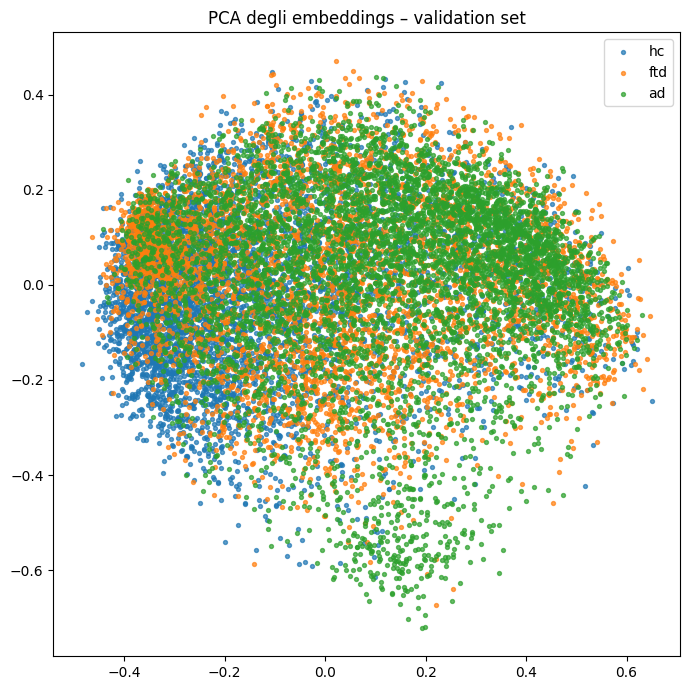

Angolo hc vs ftd: 12.1°
Angolo hc vs ad: 17.6°
Angolo ftd vs ad: 8.8°
Margine ArcFace (deg): 28.6


In [11]:
# ---------- carica annotazioni & dataset (usa il validation nel tuo caso)
annotations = pd.read_csv(ANNOT_CSV)
val_subjects = ['sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-079', 'sub-080', 'sub-081', 'sub-082', 'sub-083', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028']              # stessi del training script
val_df   = annotations[annotations['original_rec'].isin(val_subjects)]
val_ds   = CWTGraphDataset(val_df, CWT_DATA_DIR, None)
val_dl   = DataLoader(val_ds, batch_size=256, shuffle=False,
                      num_workers=8, pin_memory=False)

# ---------- ricrea modello + loss e carica pesi
num_classes    = 3
embed_dim      = 32          # deve coincidere col training
model          = GNNCWT2D_Mk11_1sec_Arc(19, (40,500), embed_dim).to(device)
loss_fn        = ArcFaceLoss(num_classes=num_classes,
                             embedding_size=embed_dim)
ckpt = torch.load(CHKPT_PATH, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
#loss_fn.load_state_dict({k.replace('module.',''): v for k,v in ckpt['optimizer_state_dict']['param_groups'][0]['params']})  # opzionale, per coerenza
model.eval()

# ---------- estrai embeddings & label
embeds, labels = [], []
with torch.no_grad():
    for data in tqdm(val_dl, ncols=100, desc='Extract'):
        data = data.to(device)
        e = model(data.x, data.edge_index, data.batch)
        embeds.append(e.cpu().numpy())
        labels.extend(data.y.cpu().numpy())
embeds = np.concatenate(embeds, axis=0)
labels = np.array(labels)

# ---------- riduzione dimensionale
proj = PCA(n_components=2).fit_transform(embeds)  # più veloce di t-SNE
# # per t-SNE: proj = TSNE(n_components=2, perplexity=30, metric='cosine').fit_transform(embeds)

# ---------- plot
class_names = ['hc','ftd','ad']
cmap = {'hc':'tab:blue','ftd':'tab:orange','ad':'tab:green'}
plt.figure(figsize=(7,7))
for cid, cname in enumerate(class_names):
    idx = labels == cid
    plt.scatter(proj[idx,0], proj[idx,1], s=8, alpha=0.7,
                label=cname, color=cmap[cname])
plt.title('PCA degli embeddings – validation set')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- opz: stampa angoli tra i centri di classe
def angle(u,v):
    cos = np.sum(u*v) / (np.linalg.norm(u)*np.linalg.norm(v) + 1e-6)
    return np.degrees(np.arccos(np.clip(cos,-1,1)))
centroids = np.vstack([embeds[labels==c].mean(0) for c in range(num_classes)])
for i in range(num_classes):
    for j in range(i+1, num_classes):
        print(f'Angolo {class_names[i]} vs {class_names[j]}: {angle(centroids[i], centroids[j]):.1f}°')
print(f'Margine ArcFace (deg): {loss_fn.margin*180/np.pi:.1f}')
